## Задание 
Ваша задача — воспроизвести результаты DQN на играх Pong и одной другой игре на ваш выбор из таблицы лекций или семинара.  Учтите, что некоторые игры могут потребовать специфических методов — например, Montezuma's Revenge. 


Детали:
Воспользуйтесь техниками из оригинальной статьи DeepMind: replay buffer, frame skip, target network.
Можно использовать любой фреймворк (stable baselines 3, clean rl).
Приветствуются улучшения базового кода или дополнительные техники.


In [ ]:
!pip install -U comet_ml
!pip install stable-baselines3[extra]
!pip install gymnasium
!pip install atari-py
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

In [2]:
import gym
import gymnasium as gym
from gymnasium import spaces
import cv2
import numpy as np
import matplotlib.pyplot as plt

from gymnasium.wrappers import AtariPreprocessing
from stable_baselines3.common.vec_env import VecFrameStack

### Логирование 

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
from comet_ml import Experiment


class CometCustomCallback(BaseCallback):
    def __init__(self, experiment: Experiment, verbose: int = 0):
        super().__init__(verbose)
        self.experiment = experiment
        self.step = 0

    def _on_step(self) -> bool:
        self.step += 1

        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                self.experiment.log_metric("reward", info["episode"]["r"], step=self.step)
                self.experiment.log_metric("length", info["episode"]["l"], step=self.step)

        # Полезно для DQN
        if hasattr(self.model, "exploration_rate"):
            self.experiment.log_metric(
                "exploration_rate", float(self.model.exploration_rate), step=self.step
            )

        return True

In [ ]:
import os
from comet_ml import Experiment, OfflineExperiment


# Вариант 1 (рекомендуется): задать ключ через переменную окружения
# os.environ["COMET_API_KEY"] = "YOUR_API_KEY"

COMET_API_KEY = os.getenv("COMET_API_KEY")

if COMET_API_KEY:
    # Впиши свой workspace (обычно это твой Comet username или org)
    experiment = Experiment(
        api_key=COMET_API_KEY,
        project_name="sb3_dqn_atari",
        workspace="YOUR_WORKSPACE",
        auto_param_logging=True,
        auto_metric_logging=False,
    )
else:
    # Если ключ не задан — offline-логирование (файлы сохранятся локально)
    experiment = OfflineExperiment(
        project_name="sb3_dqn_atari",
        offline_directory="./comet_offline",
        auto_param_logging=True,
        auto_metric_logging=False,
    )

wandb: Currently logged in as: babycar27 (cds). Use `wandb login --relogin` to force relogin


wandb: Currently logged in as: babycar27. Use `wandb login --relogin` to force relogin


### Atari wrappers

https://github.com/DLR-RM/stable-baselines3/blob/285e01f64aa8ba4bd15aa339c45876d56ed0c3b4/stable_baselines3/common/atari_wrappers.py#L250

In [16]:
from stable_baselines3.common.env_util import make_atari_env
env=make_atari_env('PongNoFrameskip-v4')

In [17]:
obs = env.reset()

Область наблюдений:  (84, 84, 1)
Max(obs) = 236 Min (obs) = 52: 


/tmp/ipykernel_12360/3982015368.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,5,1)


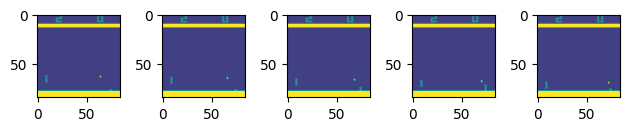

In [25]:
import matplotlib.pyplot as plt


print("Область наблюдений: ",obs[0].shape)
print(f"Max(obs) = {np.max(obs[0])} Min (obs) = {np.min(obs[0])}: ")
plt.imshow(obs[0])

for i in range(15):
    action = env.action_space.sample()
    env.step([action])

plt.subplot(1,5,1)
action = env.action_space.sample()
obs, _, _, _ = env.step([action])
plt.imshow(obs[0])

plt.subplot(1,5,2)
action = env.action_space.sample()
obs, _, _, _ = env.step([action])
plt.imshow(obs[0])

plt.subplot(1,5,3)
action = env.action_space.sample()
obs, _, _, _ = env.step([action])
plt.imshow(obs[0])

plt.subplot(1,5,4)
action = env.action_space.sample()
obs, _, _, _ = env.step([action])
plt.imshow(obs[0])

plt.subplot(1,5,5)
action = env.action_space.sample()
obs, _, _, _ = env.step([action])
plt.imshow(obs[0])

plt.tight_layout()

### Обучение

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env


env = make_atari_env("PongNoFrameskip-v4")

'''
YOUR CODE HERE
model = 

'''
callback = CometCustomCallback(experiment)
model.learn(total_timesteps=2_000_000, callback=callback)

# Корректно завершить эксперимент (особенно важно для OfflineExperiment)
experiment.end()


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/zoya/mambaforge/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 13.46GB
  warnings.warn(


Using cuda device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.5e+03  |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.983    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 429      |
|    time_elapsed     | 8        |
|    total_timesteps  | 3476     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00033  |
|    n_updates        | 843      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.57e+03 |
|    ep_rew_mean      | -20.5    |
|    exploration_rate | 0.966    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 491      |
|    time_elapsed     | 14       |
|    total_timesteps  | 7104     |
| train/              |          |
|    learning_rate    | 0.0001 